In [13]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

df=pd.read_csv("./data/training_dataset.csv",low_memory=False)
df.match_date = df.match_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [14]:
df

,player1_name,player1_atprank,player1_games,player1_wins,player1_loses,player2_name,player2_atprank,player2_games,player2_wins,player2_loses,match_date,match_location,match_tournament,match_surface,match_odd_player1,match_odd_player2,winner_player1
0,Harrison R.,481,272,117,155,Mager G.,67,59,24,35,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.72,2.00,0
1,Korda S.,26,126,75,51,Kwon S.W.,68,108,53,55,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.72,2.00,1
2,Paul T.,14,204,111,93,Nam J.S.,590,3,0,3,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.12,6.00,1
3,Kecmanovic M.,40,210,107,103,Travaglia S.,1024,81,27,54,2021-01-07,Antalya,Antalya Open,Hard,1.44,2.62,0
4,Bellucci T.,915,380,179,201,Monteiro T.,121,171,69,102,2021-01-07,Delray Beach,Delray Beach Open,Hard,3.00,1.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7057,Evans D.,30,251,124,127,Tiafoe F.,10,303,158,145,2023-08-05,Washington,Citi Open,Hard,3.75,1.29,1
7058,Griekspoor T.,37,97,47,50,Fritz T.,9,356,205,151,2023-08-06,Washington,Citi Open,Hard,3.50,1.30,1
7059,De Minaur A.,19,272,161,111,Tsitsipas S.,5,390,264,126,2023-08-06,Los Cabos,Los Cabos Open,Hard,3.20,1.36,0
7060,Evans D.,30,251,124,127,Dimitrov G.,20,651,389,262,2023-08-06,Washington,Citi Open,Hard,3.20,1.36,1


In [15]:
df = df.dropna()

In [27]:
from sklearn.model_selection import train_test_split

X = df[["player1_atprank", "player2_atprank","match_date", "match_odd_player1", "match_odd_player2"]]
y = df.winner_player1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)# shuffle=False)

In [28]:
from sklearn import preprocessing

X_train_filtered = X_train.drop("match_date",axis=1)
X_test_filtered = X_test.drop("match_date",axis=1)

#normalisation is useless for gradientboostingclassifier
#scaler = preprocessing.StandardScaler().fit(X_train_filtered)
#X_train_filtered = scaler.transform(X_train_filtered)
#X_test_filtered = scaler.transform(X_test_filtered)

X_train_filtered

,player1_atprank,player2_atprank,match_odd_player1,match_odd_player2
3191,104,111,1.72,2.10
6544,8,55,1.25,4.00
6444,76,29,1.73,2.10
2735,1024,435,1.61,2.30
2140,26,14,1.53,2.50
...,...,...,...,...
3806,2,19,1.33,3.40
1477,314,1,2.75,1.44
2364,113,7,3.40,1.33
701,136,1,3.00,1.40


In [29]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
model = model.fit(X_train_filtered, y_train)

#cross_val_score(dtree, X_test, y_test, cv=10)

y_predict = model.predict(X_test_filtered)

accuracy_score(y_predict, y_test)

0.6671408250355618

In [22]:
# ROI return of investment on all games

print("We bet 1€ on all test matches")
df_roi = X_test.copy()
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

money_invested=df_roi.shape[0]
money_won = 0.0

for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")

We bet 1€ on all test matches
money spent: 1406 €
money won: 1328.74 €
TOTAL: -77.26 €
ROI: 94.5 %


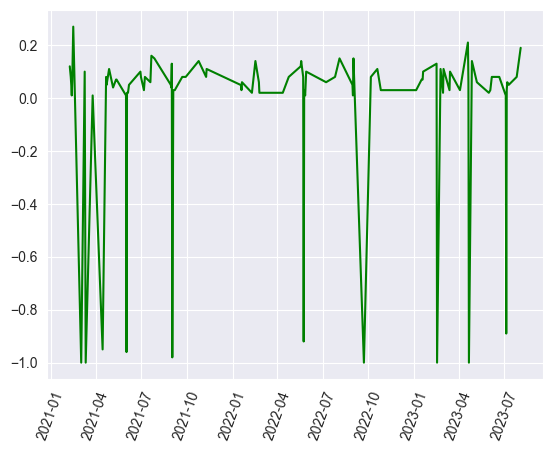

In [30]:
# on all games 
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [31]:
#only games where predict proba is > 0.8

y_predict_proba = model.predict_proba(X_test_filtered)

print("We bet 1€ on all test matches where proba score is > 0.9")
df_roi = X_test.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

df_roi= df_roi.loc[(df_roi["y_predict_proba"]>0.9) | (df_roi["y_predict_proba"]<0.1)]

money_invested=df_roi.shape[0]

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")
                

We bet 1€ on all test matches where proba score is > 0.9
money spent: 106 €
money won: 102.92 €
TOTAL: -3.08 €
ROI: 97.1 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_23112\3583309164.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


In [25]:
df_roi

,player1_atprank,player2_atprank,match_date,match_odd_player1,match_odd_player2,y_predict_proba,y_predict,y_test
786,2,30,2021-04-15,1.05,11.00,0.024495,1,0
1733,167,4,2021-07-28,6.50,1.11,0.907380,0,0
2611,69,2,2022-01-17,11.00,1.05,0.923829,0,0
4934,29,190,2022-10-19,1.11,6.50,0.062396,1,1
5782,1,37,2023-03-14,1.10,7.00,0.047643,1,1
...,...,...,...,...,...,...,...,...
5777,113,3,2023-03-13,15.00,1.03,0.968721,0,0
3039,3,149,2022-02-23,1.06,10.00,0.016395,1,1
2335,702,26,2021-10-25,5.50,1.14,0.915699,0,0
5300,120,12,2023-01-18,11.00,1.05,0.911627,0,0
